In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import sys
import scipy.optimize

sys.path.append('..') #go back 1 folder
from library import *


# Week 5

This exercise will take you through doing nonlinear optimization for triangulation of a single point. The same principles can be applied to more complex situations such as camera calibration, or situations where we lack a linear algoritm.
Construct two cameras with $\boldsymbol{R}_{1}=\boldsymbol{R}_{2}=\boldsymbol{I}, \boldsymbol{t}_{1}=\left[\begin{array}{lll}0 & 0 & 1\end{array}\right]^{\mathrm{T}}, \boldsymbol{t}_{2}=\left[\begin{array}{lll}0 & 0 & 20\end{array}\right]^{\mathrm{T}}$, and
$$
\boldsymbol{K}_{1}=\boldsymbol{K}_{2}=\left[\begin{array}{ccc}
700 & 0 & 600 \\
0 & 700 & 400 \\
0 & 0 & 1
\end{array}\right]
$$
The cameras both observe the same 3D point $Q=\left[\begin{array}{lll}1 & 1 & 0\end{array}\right]^{\mathrm{T}}$.

In [2]:
### Construct two camera matrices
R1 = np.identity(3)
R2 = np.identity(3)
t1 = np.array([[0, 0, 1]]).T
t2 = np.array([[0, 0, 20]]).T

K1 = np.array([[700, 0, 600], [0, 700, 400], [0, 0, 1]])
K2 = np.array([[700, 0, 600], [0, 700, 400], [0, 0, 1]])

Q = np.array([1, 1, 0, 1]).reshape(4, 1)

## Exercise 5.1
What are the projection matrices $\boldsymbol{P}_{1}$ and $\boldsymbol{P}_{2} ?$
What is the projection of $Q$ in cameras one and two $\left(q_{1}\right.$ and $\left.\boldsymbol{q}_{2}\right)$ ?

In [3]:
P1 = K1 @ np.hstack([R1, t1])
P2 = K2 @ np.hstack([R2, t2])
q1 = P1 @ Q
q2 = P2 @ Q
q1 = to_inhomogeneous(q1)
q2 =  to_inhomogeneous(q2)
print(q1)
print(q2)

[[1300.]
 [1100.]]
[[635.]
 [435.]]


## Exercise 5.2
To simulate noise in the detection of points, we add errors to our projections. $\tilde{\boldsymbol{q}}_{1}=\boldsymbol{q}_{1}+\left[\begin{array}{ll}1 & -1\end{array}\right]^{\mathrm{T}}, \tilde{\boldsymbol{q}}_{2}=\boldsymbol{q}_{2}+\left[\begin{array}{ll}1 & -1\end{array}\right]^{\mathrm{T}}$.
Use your function triangulate from week 3 to triangulate $\boldsymbol{Q}$ from $\left[\tilde{\boldsymbol{q}}_{1}, \tilde{\boldsymbol{q}}_{2}\right]$ and $\left[\boldsymbol{P}_{1}, \boldsymbol{P}_{2}\right]$.
Take the newly triangulated point $\tilde{\boldsymbol{Q}}$ and re-project it to the cameras. How far is it from our observations of the point $\left(\tilde{\boldsymbol{q}}_{1}, \tilde{\boldsymbol{q}}_{2}\right)$ ? In other words, what is the reprojection error for each camera?
Is this as you expected when recalling the lecture from week $3 ?$
How far is $\tilde{Q}$ from $Q$ ?

In [4]:
# Noise
q1_noisy = q1 + np.array([[1, -1]]).T
q2_noisy = q2 + np.array([[1, -1]]).T

# Triangulation
Q_tilde = np.vstack((triangulate(np.hstack([q1_noisy, q2_noisy]), [P1, P2]),1))
print("Q_tilde:")
print(Q_tilde)

# Reprojection
reprojection1 = to_inhomogeneous(P1 @ Q_tilde)
reprojection2 = to_inhomogeneous(P2 @ Q_tilde)
err1 = np.linalg.norm(q1_noisy - reprojection1) / np.linalg.norm(q1_noisy)
err2 = np.linalg.norm(q2_noisy - reprojection2) / np.linalg.norm(q2_noisy)
print("||(q1_tilde - P1 Q_tilde)|| / ||q1_tilde|| = {:.2e}".format(err1))
print("||(q2_tilde - P2 Q_tilde)|| / ||q2_tilde|| = {:.2e}".format(err2))

# Distance
Q_tilde = triangulate(np.hstack([q1_noisy, q2_noisy]), [P1, P2])
print("Absolute error: {:.0e}".format(np.linalg.norm(Q_tilde - Q[:3])))


Q_tilde:
[[1.01527507e+00]
 [9.85270570e-01]
 [2.85786810e-04]
 [1.00000000e+00]]
||(q1_tilde - P1 Q_tilde)|| / ||q1_tilde|| = 7.89e-03
||(q2_tilde - P2 Q_tilde)|| / ||q2_tilde|| = 8.72e-04
Absolute error: 2e-02


## Exercise 5.3
We are going to make a new function triangulate_nonlin that does triangulation using nonlinear optimization. It should take the same inputs as triangulate, i.e. a list of $n$ pixel coordinates (q1, $\mathrm{q} 2, \ldots, \mathrm{qn})$, and a list of $n$ projection matrices (P1, P2, .., Pn).
Start by defining a helper-function inside triangulate_nonlin.
This function, called compute_residuals, should take the parameters we want to optimize (in this case $Q$ ) as input, and should returns a vector of residuals (i.e. the numbers that we want to minimize the sum of squares of). In this case the residuals are the differences in projection, i.e.
$$
\left[\begin{array}{c}
\Pi\left(\boldsymbol{P}_{1} Q\right)-\tilde{\boldsymbol{q}}_{1} \\
\vdots
\end{array}\right]
$$

## Exercise 5.4
Use triangulate_nonlin with $\left[\tilde{\boldsymbol{q}}_{1}, \tilde{\boldsymbol{q}}_{2}\right]$ and $\left[\boldsymbol{P}_{1}, \boldsymbol{P}_{2}\right]$.
Let us call the nonlinearly estimated point $\hat{\boldsymbol{Q}}$.
What is the reprojection error of $\hat{\boldsymbol{Q}}$ to camera 1 and $2 ?$
How far is $\hat{\boldsymbol{Q}}$ from $\boldsymbol{Q} ?$
Is this an improvement over the result in Exercise 5.2?
Congratulations! You now have a useful function that does not currently exist in OpenCV!

In [5]:
Q_tilde = triangulate_nonlin(np.hstack([q1_noisy, q2_noisy]), [P1, P2])
print("Absolute error: {:.0e}".format(np.linalg.norm(Q_tilde - Q[:3])))

Absolute error: 2e-03


**WOW** That is about 10 times better using the nonlinear optimizer together with linear SVD optimizer.

# Camera Calibration OpenCV
In the following exercises you will be calibrating your own camera. For this we suggest using a
camera in your phone or similar. Disable HDR on your phone.

If you have a phone with a wide angle camera, consider using this camera for the exercise (as more
lens distortion is more fun and challenging). Remember to disable lens correction in your camera
app before taking the pictures.

## Exercise 5.5
* take pictures of the checkerboard

## Exercise 5.6
* Load images
* Resize them
* cv2.findChessbaordCorners

In [6]:
# Load and Resize
images = []
for i in range(20):
    image = get_rgb("checkerboard/c%02d.jpg" %i)
    image = cv2.resize(image, (600, 400))
    images.append(image)

# Find corners and qs
imgpoints = []
qs = []
Is = []
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7, 10))
    if ret == True:
        Is.append(img)
        imgpoints.append(corners)
        qs.append(to_homogeneous(corners.reshape(-1, 2).T))
        # Draw and display the corners
        #painted = cv2.drawChessboardCorners(img.copy(), (7, 10), corners,ret)
        #cv2.imshow('img',painted)
        #cv2.waitKey(500)
#cv2.destroyAllWindows()

## Exercise 5.7
Calibrate Camera
* Construct checkerboard points in 3D (last week exercise - z=0)
* Calibrate camera (using cv2.calibrateCamera ot last week exercise)

Homemade K
[[701.47137468 144.97984946 478.98245339]
 [  0.         572.12167147 186.73268795]
 [  0.           0.           1.        ]]
OpenCV K
[[785.09535569   0.         317.80370708]
 [  0.         635.94333842  68.32166906]
 [  0.           0.           1.        ]]
Distortion is set to 0, so d-vector will be zeroes: [[0. 0. 0. 0. 0.]]


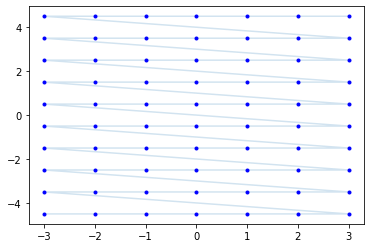

In [7]:
# HOMEMADE
checkerboard = to_homogeneous(checkerboard_points(7, 10))
plt.plot(checkerboard[0,:], checkerboard[1,:], alpha=0.2)
plt.plot(checkerboard[0,:], checkerboard[1,:], 'b.')
Hs = estimateHomographies(checkerboard, qs)
K = estimateIntrinsics(Hs)
K, Rs, ts = calibrateCamera(qs, checkerboard)
print("Homemade K")
print(K)

# OPENCV
#TODO: checkerboard might be transposed (prohozeny prvni a druhy sloupec)
objpoints = [np.float32(checkerboard[:3].T)] * len(imgpoints)
ret, K_cv2, distortion_coeff, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None, 
        flags = cv2.CALIB_FIX_K1+cv2.CALIB_FIX_K2+cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+
        cv2.CALIB_FIX_K5+cv2.CALIB_FIX_K6+cv2.CALIB_ZERO_TANGENT_DIST)
print("OpenCV K")
print(K_cv2)
print("Distortion is set to 0, so d-vector will be zeroes:", distortion_coeff)

## Exercise 5.8
Reproject the checkerboard corners to the images.
Tip: cv2. calibrateCamera returns rvecs, which are the $\boldsymbol{R}$ matrices stored in axis-angle representation. You can convert them to rotation matrices with cv2. Rodrigues.

Compute the reprojection error for each frame. Find the frame with the highest reprojection error and show both the detected and reprojected corner points. Hopefully you have an RMSE of a few pixels.

Highest homemade reprojection error (summed on corners): 8.642 pixels
Highest cv reprojection error (summed on corners): 74.580 pixels


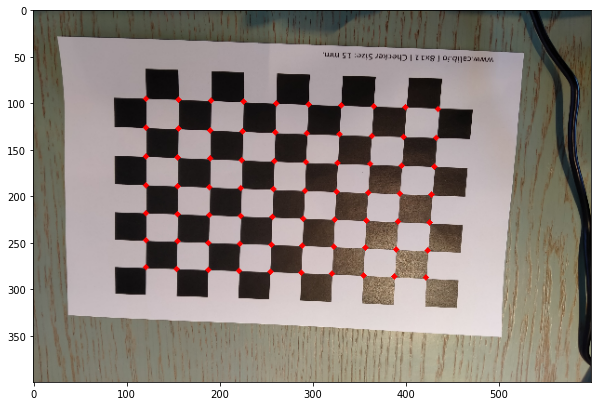

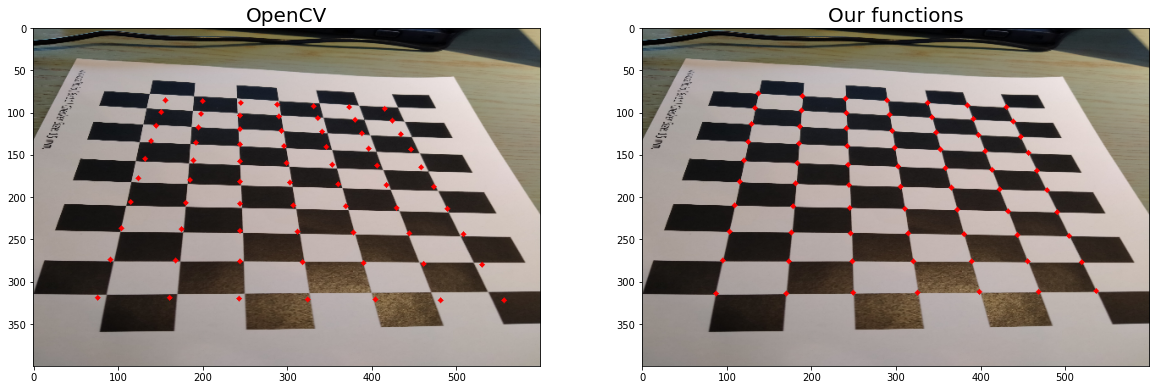

In [8]:
# HOMEMADE
qs_reprojected, I_projection = get_reprojection_images(checkerboard, Is, K, Rs, ts)
absolute_error = [np.linalg.norm(qs[i] - qs_reprojected[i]) for i in range(len(Is))]
i_max_error = np.argmax(absolute_error)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(I_projection[i_max_error])
fig.savefig('ex5_plot1.jpg', bbox_inches='tight',dpi=500)
print("Highest homemade reprojection error (summed on corners): {:.3f} pixels".format(absolute_error[i_max_error]))

# OPENCV2
Rs_cv = []
for rvec in rvecs:
    R, _ = cv2.Rodrigues(rvec)
    Rs_cv.append(R)
ts_cv = np.asarray(tvecs)
qs_reprojected_cv, I_projection_cv = get_reprojection_images(checkerboard,Is, K_cv2, Rs_cv, ts_cv)
absolute_error = [np.linalg.norm(qs[i] - qs_reprojected_cv[i]) for i in range(len(Is))]
i_max_error = np.argmax(absolute_error)

# PLOT
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(I_projection_cv[i_max_error])
ax[1].imshow(I_projection[i_max_error])
ax[0].set_title("OpenCV", fontsize=20)
ax[1].set_title("Our functions", fontsize=20)
fig.savefig('ex5_plot2.jpg', bbox_inches='tight',dpi=500)

print("Highest cv reprojection error (summed on corners): {:.3f} pixels".format(absolute_error[i_max_error]))

**WOW** It seems the homemade calibration is a also working despite the doubts from last week!

## Exercise 5.9
Try changing your distortion model to include $k_{1}$ and $k_{2}$.
Do you get a lower reprojection error?
If your camera has visible lens distortion, try using the function from week 2 to undistort one of your images.

[ 0.07642424 -0.64188297  0.          0.          0.        ]
Highest reprojection error (summed on corners): 296.049 pixels


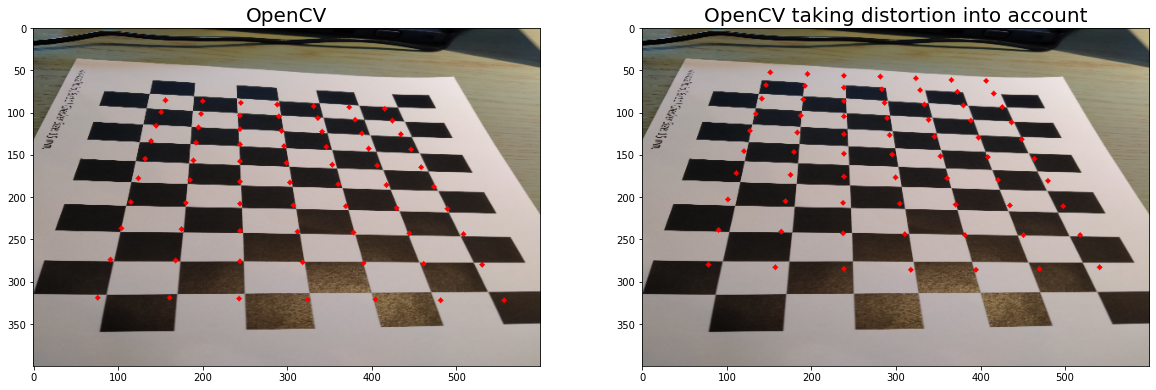

In [9]:
# RERUN OPENCV NOW WITH DISTORTION
ret, K_cv2, distortion_coeff, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None, 
        flags = cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+
        cv2.CALIB_FIX_K5+cv2.CALIB_FIX_K6+cv2.CALIB_ZERO_TANGENT_DIST)
print(distortion_coeff[0])
qs_reprojected_d, I_projection_d = get_reprojection_images(checkerboard,Is, K_cv2, Rs_cv, ts_cv,distortion_coeff[0][:3])
absolute_error = [np.linalg.norm(qs[i] - qs_reprojected_d[i]) for i in range(len(Is))]
i_max_error = np.argmax(absolute_error)

# PLOT
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(I_projection_cv[i_max_error])
ax[1].imshow(I_projection_d[i_max_error])
ax[0].set_title("OpenCV", fontsize=20)
ax[1].set_title("OpenCV taking distortion into account", fontsize=20)
fig.savefig('ex5_plot3.jpg', bbox_inches='tight',dpi=500)
print("Highest reprojection error (summed on corners): {:.3f} pixels".format(absolute_error[i_max_error]))

The results should have been a bit better, dunno why it is worst.
Nevertheless the problem is not in distortion but in OpenCV2 Calibration